<a href="https://colab.research.google.com/github/sirthirrygolooo/CICIoV2024-Dataset-Analysis-Project/blob/main/ProjetIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet IDS - Dataset IOT devices

**Dataset** : Advancing Realistic IDS Approaches against DoS and Spoofing Attack in IoV CAN bus

## Dataset Downloading and extraction

In [1]:
import requests
import tarfile
import os

# URL brute du fichier tar.xz
url = "https://github.com/sali446/CICIoV2024/raw/26a888050a38de73a1490af7b5e3e1c42a61559c/CICIoV2024.tar.xz"

# Nom du fichier local
filename = "CICIoV2024.tar.xz"

# Télécharger le fichier
response = requests.get(url, stream=True)

if response.status_code == 200:
    # Écrire le contenu du fichier
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"Fichier {filename} téléchargé avec succès.")
else:
    print(f"Échec du téléchargement. Code statut: {response.status_code}")

# Vérifier si le fichier a été téléchargé
if os.path.exists(filename):
    try:
        # Décompresser le fichier tar.xz
        with tarfile.open(filename, 'r:xz') as tar:
            tar.extractall()  # Extraction dans le répertoire courant
            print("Extraction terminée.")

        # Optionnel : Supprimer le fichier tar.xz après extraction
        os.remove(filename)
    except tarfile.ReadError:
        print(f"Erreur lors de la lecture du fichier {filename}. Le format pourrait être incorrect.")
else:
    print(f"Le fichier {filename} n'existe pas.")


Fichier CICIoV2024.tar.xz téléchargé avec succès.
Extraction terminée.


1. Load the selected dataset (e.g. into a Pandas DataFrame using appropriate functions like “pd.read csv()”
in the case of tabular/time series datasets).

In [2]:
!pip install xgboost
!pip install lightgbm
!pip install scikit-learn
!pip install shap

In [3]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import time

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
df_DoS = pd.read_csv('decimal/decimal_DoS.csv')
df_Benign = pd.read_csv('decimal/decimal_benign.csv')
df_spoofing_Gas = pd.read_csv('decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('decimal/decimal_spoofing-STEERING_WHEEL.csv')
df = pd.concat([df_DoS, df_Benign, df_spoofing_Gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering])
df.set_index('ID', inplace=True)
df_notclean = df.copy()
df_spoofing = pd.concat([df_spoofing_Gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering])

df

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,category,specific_class
ID,,,,,,,,,,,
291,0,0,0,0,0,0,0,0,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
...,...,...,...,...,...,...,...,...,...,...,...
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL


## Data Cleaning

In [5]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['BENIGN', 'ATTACK']))
    print("\n")



def plot_feature_importance(model, model_name, feature_names, top_number=None):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]

    if top_number is not None:
        indices = indices[:top_number]

    top_importance = importance[indices]
    top_features = [feature_names[i] for i in indices]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance - Top {len(top_features)} Features - {model_name}")
    plt.bar(range(len(top_features)), top_importance, align="center")
    plt.xticks(range(len(top_features)), top_features, rotation=90)
    plt.tight_layout()
    plt.show()


def train_and_evaluate(models, X_train, X_test, y_train, y_test, dataset_name):
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test, f"{model_name} {dataset_name}")
        plot_normalized_confusion_matrix(model, X_test, y_test, f"{model_name} {dataset_name}")
        plot_feature_importance(model, f"{model_name} {dataset_name}", X_test.columns)

def prepare_data(df):
    X = df.drop(columns=['isAttack'])
    y = LabelEncoder().fit_transform(df['isAttack'])
    return train_test_split(X, y, test_size=0.2, random_state=42)

def prepare_data_dos(df):
    X = df.drop(columns=['isDos'])
    y = LabelEncoder().fit_transform(df['isDos'])
    return train_test_split(X, y, test_size=0.2, random_state=42)


def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['BENIGN', 'ATTACK'],
                yticklabels=['BENIGN', 'ATTACK'])
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies valeurs")
    plt.tight_layout()
    plt.show()

def get_errors(X_test, y_test, y_pred):
    misclassified = X_test[y_test != y_pred]
    print("Erreurs :")
    print(misclassified)

def analyze_execution_time(models, X_train, y_train):
    execution_times = []

    for model_name, model in models.items():
        start_time = time.time()

        model.fit(X_train, y_train)

        end_time = time.time()
        execution_time = end_time - start_time

        execution_times.append((model_name, execution_time))

        print(f"{model_name} a pris {execution_time:.4f} secondes")

    exec_df = pd.DataFrame(execution_times, columns=['Model', 'Execution Time'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Execution Time', data=exec_df, palette='Set2')
    plt.title('Temps d\'exécution des modèles')
    plt.xlabel('Modèle')
    plt.ylabel('Temps d\'exécution (secondes)')
    plt.show()

    return exec_df

def aggregate_columns(df, id_column, group_size, excluded_columns=None):
    if excluded_columns is None:
        excluded_columns = []

    aggregated_data = []

    grouped = df.groupby(id_column)

    for id_value, group in grouped:
        for i in range(0, len(group), group_size):
            sub_group = group.iloc[i:i + group_size]
            mean_values = sub_group.drop(columns=excluded_columns).mean(axis=0).round().astype(int)
            for col in excluded_columns:
                if col in sub_group.columns:
                    mean_values[col] = sub_group[col].iloc[0]
            mean_values[id_column] = id_value
            aggregated_data.append(mean_values)

    aggregated_df = pd.DataFrame(aggregated_data)

    return aggregated_df

def aggregate_columns2(df, id_column, group_size=100, excluded_columns=None):
    if excluded_columns is None:
        excluded_columns = []

    # df['unique'] = df.drop(columns=excluded_columns, errors='ignore').nunique(axis=1)
    aggregated_columns = df.T.groupby(df.columns).sum().T

    aggregated_data = []

    grouped = aggregated_columns.groupby(id_column)

    for id_value, group in grouped:
        for i in range(0, len(group), group_size):
            sub_group = group.iloc[i:i + group_size]

            mean_values = sub_group.drop(columns=excluded_columns, errors='ignore').mean(axis=0).round().astype(int)

            for col in excluded_columns:
                if col in sub_group.columns:
                    mean_values[col] = int(sub_group[col].iloc[0])

            mean_values[id_column] = id_value

            aggregated_data.append(mean_values)

    aggregated_df = pd.DataFrame(aggregated_data)

    return aggregated_df


def aggregate_binary_dataframe(df,id_prefix='ID', group_size=50, excluded_columns=None):
    if excluded_columns is None:
        excluded_columns = []

    id_columns = [col for col in df.columns if col.startswith(id_prefix)]
    aggregated_data = []
    grouped = df.groupby(id_columns)

    for id_values, group in grouped:
        for i in range(0, len(group), group_size):
            sub_group = group.iloc[i:i + group_size]

            mean_values = sub_group.drop(columns=excluded_columns + id_columns).mean(axis=0)

            for col in excluded_columns:
                if col in sub_group.columns:
                    mean_values[col] = sub_group[col].iloc[0]

            for id_col in id_columns:
                mean_values[id_col] = sub_group[id_col].iloc[0]

            aggregated_data.append(mean_values)

    aggregated_df = pd.DataFrame(aggregated_data)

    return aggregated_df


def plot_normalized_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

    plt.title(f"Normalized Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.show()


def diagnosticv1(models, df):
    X, y = df.drop(columns=['isMechant', 'is_spoofing']), df['isMechant']
    if y.nunique() <= 1:
        print("[!] Insufficient target class diversity for 'isMechant'. Skipping...")
        return

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


    results = []
    total_correct_attack = 0
    total_incorrect_attack = 0
    total_correct_spoof = 0
    total_incorrect_spoof = 0
    execution_times = []

    for model_name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm_attack = confusion_matrix(y_test, y_pred)
        correct_predictions_attack = np.trace(cm_attack)
        incorrect_predictions_attack = cm_attack.sum() - correct_predictions_attack
        total_correct_attack += correct_predictions_attack
        total_incorrect_attack += incorrect_predictions_attack
        execution_time = time.time() - start_time
        execution_times.append(execution_time)

        spoofing_df = df[df['isMechant'] == 1]
        if len(spoofing_df) > 0:
            X_spoof, y_spoof = spoofing_df.drop(columns=['isMechant', 'is_spoofing']), spoofing_df['is_spoofing']
            X_train_spoof, X_test_spoof, y_train_spoof, y_test_spoof = train_test_split(X_spoof, y_spoof, test_size=0.2, random_state=42)

            model_secondary = model
            model_secondary.fit(X_train_spoof, y_train_spoof)
            y_pred_spoof = model_secondary.predict(X_test_spoof)

            cm_spoof = confusion_matrix(y_test_spoof, y_pred_spoof)
            correct_predictions_spoof = np.trace(cm_spoof)
            incorrect_predictions_spoof = cm_spoof.sum() - correct_predictions_spoof
            total_correct_spoof += correct_predictions_spoof
            total_incorrect_spoof += incorrect_predictions_spoof

            results.append({
                'Model': model_name,
                'Correct Predictions (Attack)': correct_predictions_attack,
                'Incorrect Predictions (Attack)': incorrect_predictions_attack,
                'Correct Predictions (Spoofing)': correct_predictions_spoof,
                'Incorrect Predictions (Spoofing)': incorrect_predictions_spoof,
                'Execution Time (s)': execution_time
            })

    df_results = pd.DataFrame(results)

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    total_cm_attack = np.array([[total_correct_attack, total_incorrect_attack],
                                [total_incorrect_attack, total_correct_attack]])
    sns.heatmap(total_cm_attack, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix: Attack Detection')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    total_cm_spoof = np.array([[total_correct_spoof, total_incorrect_spoof],
                               [total_incorrect_spoof, total_correct_spoof]])
    sns.heatmap(total_cm_spoof, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1])
    axes[0, 1].set_title('Confusion Matrix: Spoofing Detection')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')

    width = 0.35
    x = np.arange(len(models))
    axes[1, 0].bar(x - width / 2, df_results['Correct Predictions (Attack)'], width, label='Correct Attack', color='green')
    axes[1, 0].bar(x - width / 2, df_results['Incorrect Predictions (Attack)'], width, bottom=df_results['Correct Predictions (Attack)'], color='red')

    axes[1, 0].bar(x + width / 2, df_results['Correct Predictions (Spoofing)'], width, label='Correct Spoofing', color='blue')
    axes[1, 0].bar(x + width / 2, df_results['Incorrect Predictions (Spoofing)'], width, bottom=df_results['Correct Predictions (Spoofing)'], color='orange')

    axes[1, 0].set_title('Correct and Incorrect Predictions per Model')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(df_results['Model'])
    axes[1, 0].legend()

    sns.boxplot(data=execution_times, ax=axes[1, 1], color='purple')
    axes[1, 1].set_title('Execution Time Distribution')
    axes[1, 1].set_ylabel('Time (s)')
    axes[1, 1].set_xticklabels(["Execution Time"])

    plt.tight_layout()
    plt.show()

    print("\n--- Results Summary ---")
    print(df_results)
    print(f"\nTotal Correct Predictions (Attack): {total_correct_attack}")
    print(f"Total Incorrect Predictions (Attack): {total_incorrect_attack}")
    print(f"Total Correct Predictions (Spoofing): {total_correct_spoof}")
    print(f"Total Incorrect Predictions (Spoofing): {total_incorrect_spoof}")

    return df_results

def diagnosticv2(models, df):
    X, y = df.drop(columns=['isMechant', 'is_spoofing']), df['isMechant']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results = []
    total_correct_dos = 0
    total_incorrect_dos = 0
    total_correct_spoof = 0
    total_incorrect_spoof = 0
    execution_times = []

    for model_name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm_attack = confusion_matrix(y_test, y_pred)
        attack_correct = np.trace(cm_attack)
        attack_incorrect = cm_attack.sum() - attack_correct
        execution_time = time.time() - start_time
        execution_times.append(execution_time)

        spoofing_df = df[df['isMechant'] == 1]
        if len(spoofing_df) > 0:
            X_spoof, y_spoof = spoofing_df.drop(columns=['isMechant', 'is_spoofing']), spoofing_df['is_spoofing']
            X_train_spoof, X_test_spoof, y_train_spoof, y_test_spoof = train_test_split(X_spoof, y_spoof, test_size=0.2, random_state=42)

            model_secondary = model
            model_secondary.fit(X_train_spoof, y_train_spoof)
            y_pred_spoof = model_secondary.predict(X_test_spoof)

            cm_spoof = confusion_matrix(y_test_spoof, y_pred_spoof)
            correct_spoof = np.trace(cm_spoof)
            incorrect_spoof = cm_spoof.sum() - correct_spoof

            correct_dos = attack_correct - correct_spoof
            incorrect_dos = attack_incorrect - incorrect_spoof

            total_correct_dos += correct_dos
            total_incorrect_dos += incorrect_dos
            total_correct_spoof += correct_spoof
            total_incorrect_spoof += incorrect_spoof

            results.append({
                'Model': model_name,
                'Correct Predictions (DoS)': correct_dos,
                'Incorrect Predictions (DoS)': incorrect_dos,
                'Correct Predictions (Spoofing)': correct_spoof,
                'Incorrect Predictions (Spoofing)': incorrect_spoof,
                'Execution Time (s)': execution_time
            })

    df_results = pd.DataFrame(results)

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))


    total_cm_attack = np.array([[total_correct_dos, total_incorrect_dos],
                                [total_incorrect_dos, total_correct_dos]])
    sns.heatmap(total_cm_attack, annot=True, fmt='d', cmap='Greens', ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix: DoS Detection')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    total_cm_spoof = np.array([[total_correct_spoof, total_incorrect_spoof],
                               [total_incorrect_spoof, total_correct_spoof]])
    sns.heatmap(total_cm_spoof, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1])
    axes[0, 1].set_title('Confusion Matrix: Spoofing Detection')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')

    width = 0.35
    x = np.arange(len(models))
    axes[1, 0].bar(x - width / 2, df_results['Correct Predictions (DoS)'], width, label='Correct DoS', color='green')
    axes[1, 0].bar(x - width / 2, df_results['Incorrect Predictions (DoS)'], width, bottom=df_results['Correct Predictions (DoS)'], color='red')

    axes[1, 0].bar(x + width / 2, df_results['Correct Predictions (Spoofing)'], width, label='Correct Spoofing', color='blue')
    axes[1, 0].bar(x + width / 2, df_results['Incorrect Predictions (Spoofing)'], width, bottom=df_results['Correct Predictions (Spoofing)'], color='orange')

    axes[1, 0].set_title('Correct and Incorrect Predictions per Model')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(df_results['Model'])
    axes[1, 0].legend()

    sns.boxplot(data=execution_times, ax=axes[1, 1], color='purple')
    axes[1, 1].set_title('Execution Time Distribution')
    axes[1, 1].set_ylabel('Time (s)')
    axes[1, 1].set_xticklabels(["Execution Time"])

    plt.tight_layout()
    plt.show()

    print("\n--- Results Summary ---")
    print(df_results)
    print(f"\nTotal Correct Predictions (DoS): {total_correct_dos}")
    print(f"Total Incorrect Predictions (DoS): {total_incorrect_dos}")
    print(f"Total Correct Predictions (Spoofing): {total_correct_spoof}")
    print(f"Total Incorrect Predictions (Spoofing): {total_incorrect_spoof}")

    return df_results

def diagnosticv3(models, df):
    X, y = df.drop(columns=['isMechant', 'is_spoofing', 'spoofing_type']), df['isMechant']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results = []
    total_correct_dos = 0
    total_incorrect_dos = 0
    total_correct_spoof = 0
    total_incorrect_spoof = 0
    total_correct_types = 0
    total_incorrect_types = 0
    execution_times = []

    for model_name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm_attack = confusion_matrix(y_test, y_pred)
        attack_correct = np.trace(cm_attack)
        attack_incorrect = cm_attack.sum() - attack_correct
        execution_time = time.time() - start_time
        execution_times.append(execution_time)

        spoofing_df = df[df['isMechant'] == 1]
        if len(spoofing_df) > 0:
            X_spoof, y_spoof = spoofing_df.drop(columns=['isMechant', 'is_spoofing', 'spoofing_type']), spoofing_df['is_spoofing']
            X_train_spoof, X_test_spoof, y_train_spoof, y_test_spoof = train_test_split(X_spoof, y_spoof, test_size=0.2, random_state=42)

            model_secondary = model
            model_secondary.fit(X_train_spoof, y_train_spoof)
            y_pred_spoof = model_secondary.predict(X_test_spoof)

            cm_spoof = confusion_matrix(y_test_spoof, y_pred_spoof)
            correct_spoof = np.trace(cm_spoof)
            incorrect_spoof = cm_spoof.sum() - correct_spoof

            spoof_type_df = spoofing_df[spoofing_df['is_spoofing'] == 1]
            if len(spoof_type_df) > 0:
                X_type, y_type = spoof_type_df.drop(columns=['isMechant', 'is_spoofing', 'spoofing_type']), spoof_type_df['spoofing_type']
                X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(X_type, y_type, test_size=0.2, random_state=42)

                model_tertiary = model
                model_tertiary.fit(X_train_type, y_train_type)
                y_pred_type = model_tertiary.predict(X_test_type)

                cm_type = confusion_matrix(y_test_type, y_pred_type)
                correct_types = np.trace(cm_type)
                incorrect_types = cm_type.sum() - correct_types
            else:
                correct_types = 0
                incorrect_types = 0

            correct_dos = attack_correct - correct_spoof
            incorrect_dos = attack_incorrect - incorrect_spoof

            total_correct_dos += correct_dos
            total_incorrect_dos += incorrect_dos
            total_correct_spoof += correct_spoof
            total_incorrect_spoof += incorrect_spoof
            total_correct_types += correct_types
            total_incorrect_types += incorrect_types

            results.append({
                'Model': model_name,
                'Correct Predictions (DoS)': correct_dos,
                'Incorrect Predictions (DoS)': incorrect_dos,
                'Correct Predictions (Spoofing)': correct_spoof,
                'Incorrect Predictions (Spoofing)': incorrect_spoof,
                'Correct Predictions (Spoofing Type)': correct_types,
                'Incorrect Predictions (Spoofing Type)': incorrect_types,
                'Execution Time (s)': execution_time
            })

    df_results = pd.DataFrame(results)

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    total_cm_attack = np.array([[total_correct_dos, total_incorrect_dos],
                                [total_incorrect_dos, total_correct_dos]])
    sns.heatmap(total_cm_attack, annot=True, fmt='d', cmap='Greens', ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix: DoS Detection')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    total_cm_spoof = np.array([[total_correct_spoof, total_incorrect_spoof],
                               [total_incorrect_spoof, total_correct_spoof]])
    sns.heatmap(total_cm_spoof, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1])
    axes[0, 1].set_title('Confusion Matrix: Spoofing Detection')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')

    total_cm_type = np.array([[total_correct_types, total_incorrect_types],
                              [total_incorrect_types, total_correct_types]])
    sns.heatmap(total_cm_type, annot=True, fmt='d', cmap='Purples', ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix: Spoofing Type Classification')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')

    sns.boxplot(data=execution_times, ax=axes[1, 1], color='blue')
    axes[1, 1].set_title('Execution Time Distribution')
    axes[1, 1].set_ylabel('Time (s)')
    axes[1, 1].set_xticklabels(["Execution Time"])

    plt.tight_layout()
    plt.show()


    print("\n--- Results Summary ---")
    print(df_results)
    print(f"\nTotal Correct Predictions (DoS): {total_correct_dos}")
    print(f"Total Incorrect Predictions (DoS): {total_incorrect_dos}")
    print(f"Total Correct Predictions (Spoofing): {total_correct_spoof}")
    print(f"Total Incorrect Predictions (Spoofing): {total_incorrect_spoof}")
    print(f"Total Correct Predictions (Spoofing Type): {total_correct_types}")
    print(f"Total Incorrect Predictions (Spoofing Type): {total_incorrect_types}")

    return df_results

def diagnostic_final(models, df):

    X, y = df.drop(columns=['isMechant', 'is_spoofing', 'spoofing_type']), df['isMechant']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results = []
    execution_times = []

    for model_name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm_attack = confusion_matrix(y_test, y_pred)
        accuracy_attack = accuracy_score(y_test, y_pred)
        execution_time = time.time() - start_time
        execution_times.append(execution_time)

        spoofing_df = df[df['isMechant'] == 1]
        if len(spoofing_df) > 0:
            X_spoof, y_spoof = spoofing_df.drop(columns=['isMechant', 'is_spoofing', 'spoofing_type']), spoofing_df['is_spoofing']
            X_train_spoof, X_test_spoof, y_train_spoof, y_test_spoof = train_test_split(X_spoof, y_spoof, test_size=0.2, random_state=42)

            model_secondary = model
            model_secondary.fit(X_train_spoof, y_train_spoof)
            y_pred_spoof = model_secondary.predict(X_test_spoof)

            cm_spoof = confusion_matrix(y_test_spoof, y_pred_spoof)
            accuracy_spoof = accuracy_score(y_test_spoof, y_pred_spoof)
        else:
            cm_spoof = None
            accuracy_spoof = None

        spoof_type_df = spoofing_df[spoofing_df['is_spoofing'] == 1]
        if len(spoof_type_df) > 0:
            X_type, y_type = spoof_type_df.drop(columns=['isMechant', 'is_spoofing', 'spoofing_type']), spoof_type_df['spoofing_type']
            X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(X_type, y_type, test_size=0.2, random_state=42)

            model_tertiary = model
            model_tertiary.fit(X_train_type, y_train_type)
            y_pred_type = model_tertiary.predict(X_test_type)

            cm_type = confusion_matrix(y_test_type, y_pred_type)
            accuracy_type = accuracy_score(y_test_type, y_pred_type)
        else:
            cm_type = None
            accuracy_type = None

        results.append({
            'Model': model_name,
            'Attack Accuracy': accuracy_attack,
            'Spoofing Accuracy': accuracy_spoof if accuracy_spoof is not None else "N/A",
            'Spoofing Type Accuracy': accuracy_type if accuracy_type is not None else "N/A",
            'Execution Time (s)': execution_time,
            'Confusion Matrix (Attack)': cm_attack,
            'Confusion Matrix (Spoofing)': cm_spoof,
            'Confusion Matrix (Type)': cm_type
        })

    results_df = pd.DataFrame(results)

    print("\n" + "="*30)
    print("       MODEL PERFORMANCE SUMMARY       ")
    print("="*30)
    for idx, row in results_df.iterrows():
        print(f"\n### Model: {row['Model']} ###")
        print(f"- Attack Detection Accuracy: {row['Attack Accuracy']:.2%}")
        print("  Confusion Matrix (DoS Detection):")
        print(row['Confusion Matrix (Attack)'])

        if row['Spoofing Accuracy'] != "N/A":
            print(f"\n- Spoofing Detection Accuracy: {row['Spoofing Accuracy']:.2%}")
            print("  Confusion Matrix (Spoofing Detection):")
            print(row['Confusion Matrix (Spoofing)'])

        if row['Spoofing Type Accuracy'] != "N/A":
            print(f"\n- Spoofing Type Classification Accuracy: {row['Spoofing Type Accuracy']:.2%}")
            print("  Confusion Matrix (Spoofing Type):")
            print(row['Confusion Matrix (Type)'])

        print(f"- Execution Time: {row['Execution Time (s)']:.2f} seconds")
        print("-" * 30)

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    results_df.plot(kind='bar', x='Model', y=['Attack Accuracy', 'Spoofing Accuracy', 'Spoofing Type Accuracy'],
                    ax=ax[0], color=['green', 'orange', 'purple'], rot=45)
    ax[0].set_title("Model Accuracies for Detection Tasks")
    ax[0].set_ylabel("Accuracy")

    sns.boxplot(data=results_df['Execution Time (s)'], ax=ax[1], color='blue')
    ax[1].set_title("Model Execution Time Distribution")
    ax[1].set_ylabel("Execution Time (s)")
    ax[1].set_xticklabels(["Execution Time"])

    plt.tight_layout()
    plt.show()

    return results_df

We used data cleaning at first by deleting duplicates but it was not the best option because we needed all the datas

In [6]:
df.dropna(inplace=True)

# df.drop_duplicates(inplace=True) ## Fait passer le df à 3000 input
# df.sort_index(inplace=True)
df

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,category,specific_class
ID,,,,,,,,,,,
291,0,0,0,0,0,0,0,0,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
...,...,...,...,...,...,...,...,...,...,...,...
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL


## Data Analysis


Summary of the attack dataframe

In [7]:
df_attack = df[df['label'] == 'ATTACK']

atk_view = df_attack.describe()

## Chart

Count of the both type of attacks, and the repartition in

<Axes: xlabel='category', ylabel='Count'>

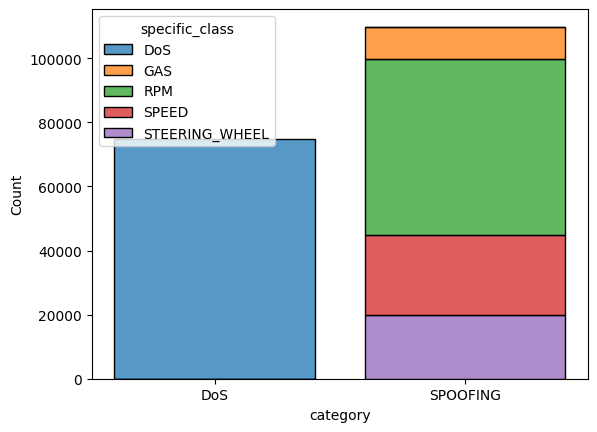

In [8]:
value = df_attack
sns.histplot(
    data=value, x='category',
    hue='specific_class',
    multiple="stack",
    shrink=0.8
)

Create a dataframe with only the attack and one with only benign + features selection



In [9]:
del df_attack['category']
del df_attack['specific_class']
df_attack.describe()

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7
count,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000
mean,32.413412,14.466029,26.558358,33.168521,19.207294,10.718141,31.836781,21.506640
std,58.843930,15.714449,58.633819,51.342103,39.296997,15.287561,53.777657,32.430176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,2.000000,5.000000,0.000000,0.000000,1.000000,0.000000
50%,6.000000,11.000000,6.000000,13.000000,6.000000,5.000000,5.000000,11.000000
75%,14.000000,16.000000,13.000000,37.000000,14.000000,13.000000,14.000000,34.000000
max,194.000000,61.000000,245.000000,239.000000,168.000000,53.000000,148.000000,156.000000


In [10]:
df_benign = pd.read_csv('decimal/decimal_benign.csv')
del df_benign['category']
del df_benign['specific_class']
del df_benign['ID']

# Data cleaning
df_benign.dropna(inplace=True)

df_benign.describe()

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7
count,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06
mean,7.691670e+01,7.835954e+01,5.930063e+01,6.111469e+01,4.921648e+01,6.038979e+01,7.776605e+01,6.611918e+01
std,9.126328e+01,9.970725e+01,7.371815e+01,9.427600e+01,6.656173e+01,9.941050e+01,1.057676e+02,1.052630e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.800000e+01,1.300000e+01,1.600000e+01,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.270000e+02,1.280000e+02,1.270000e+02,1.120000e+02,1.130000e+02,7.900000e+01,2.270000e+02,1.280000e+02
max,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02


Show the correlation between data changement with benign and attack value

Count Plot for DATA_VALUE

<ipython-input-11-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


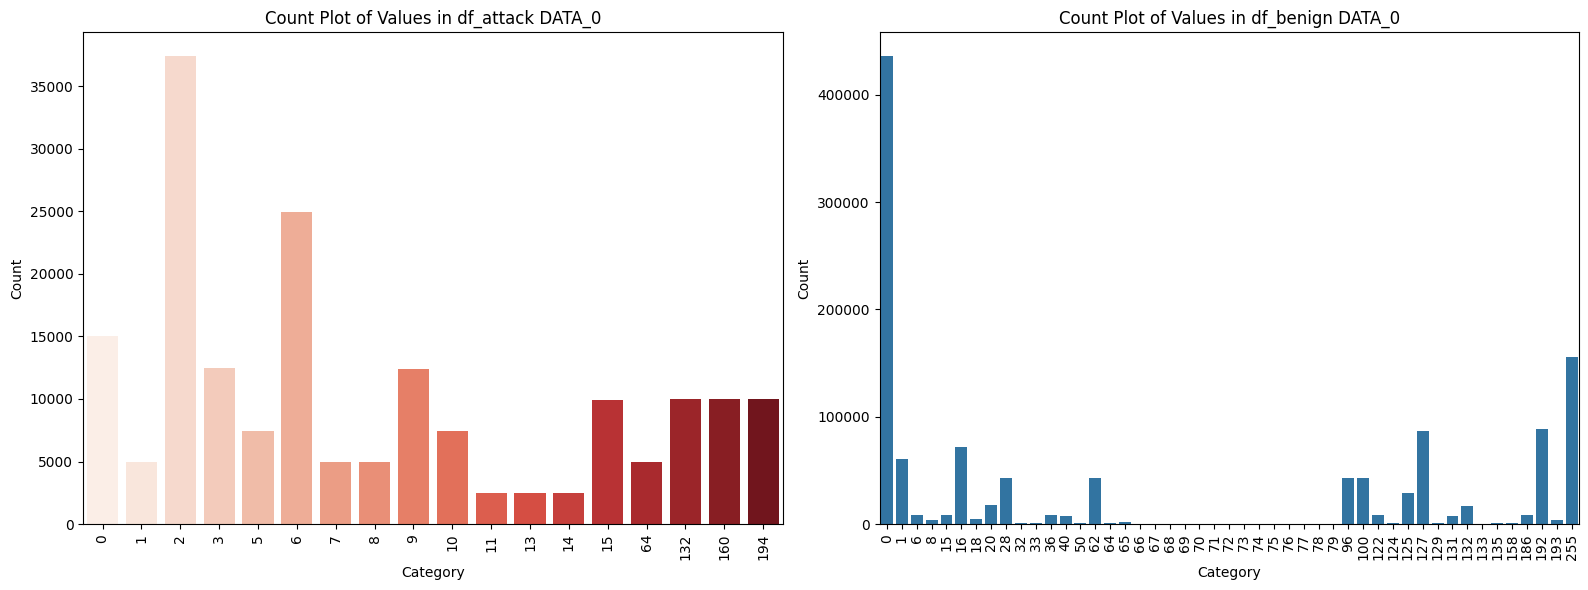

<ipython-input-11-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


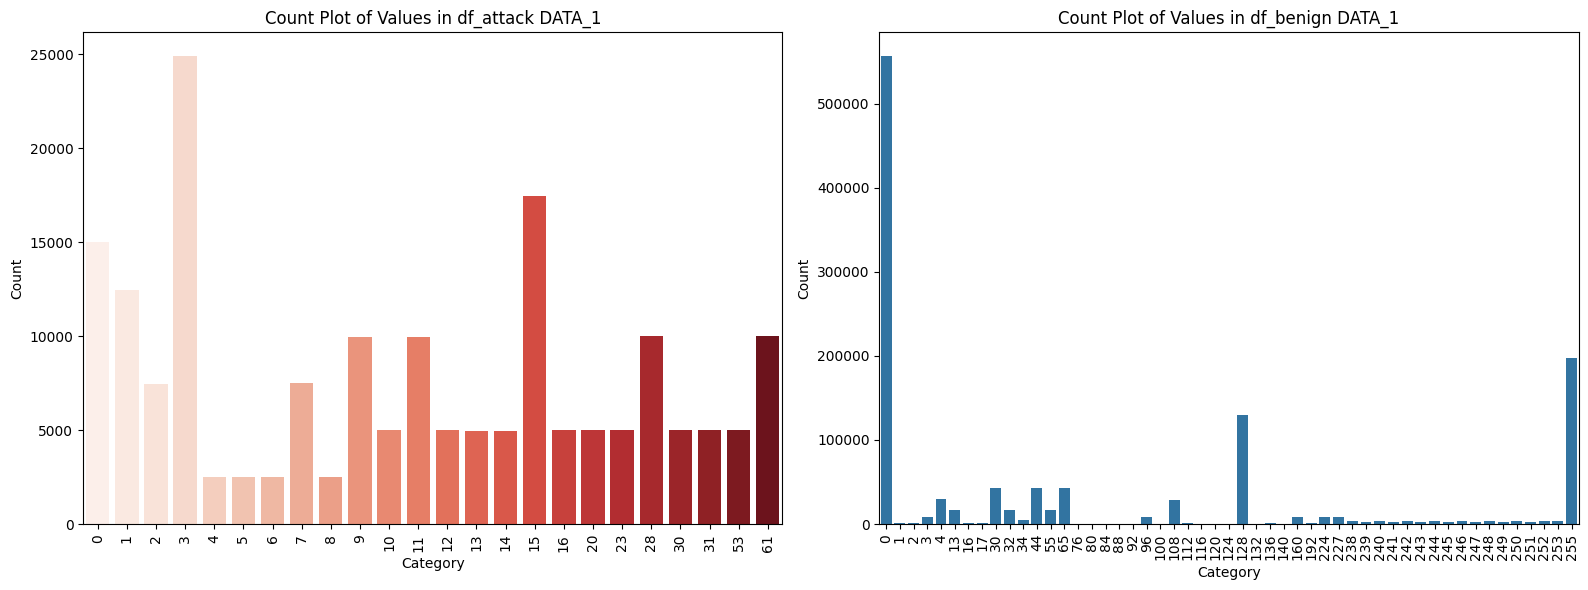

<ipython-input-11-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


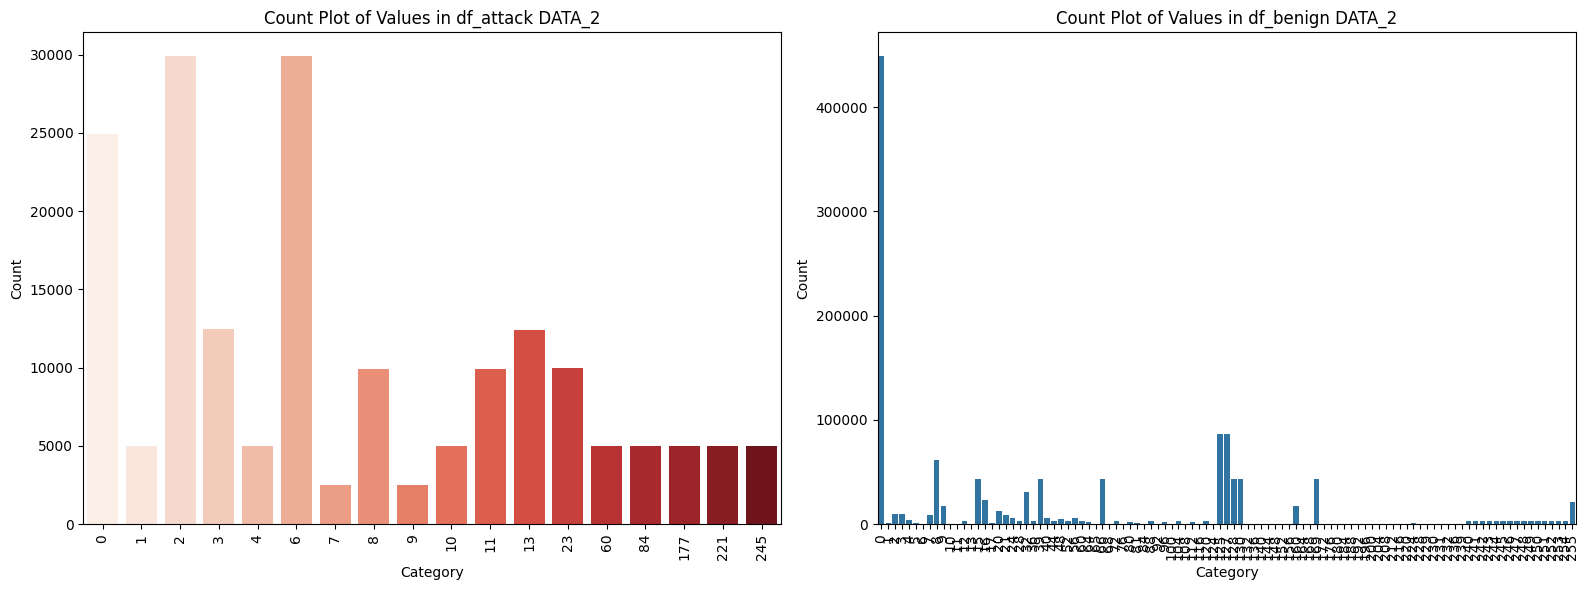

<ipython-input-11-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


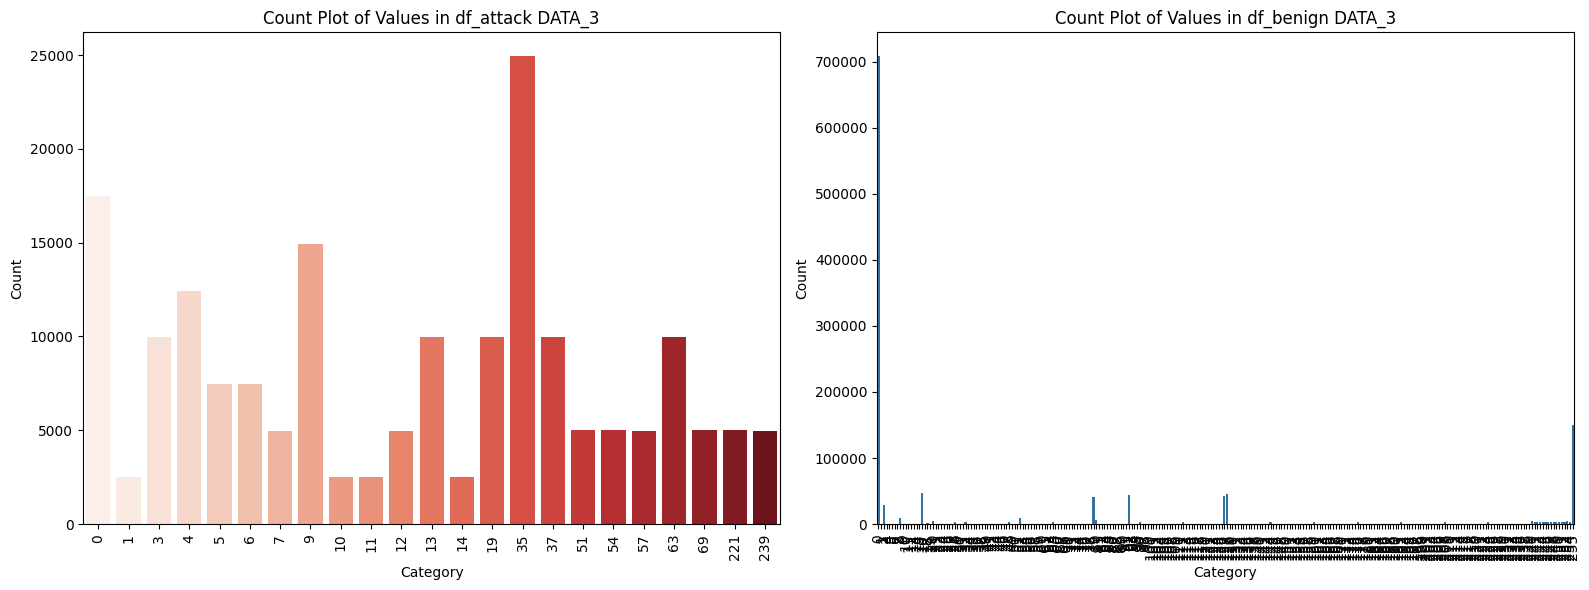

<ipython-input-11-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


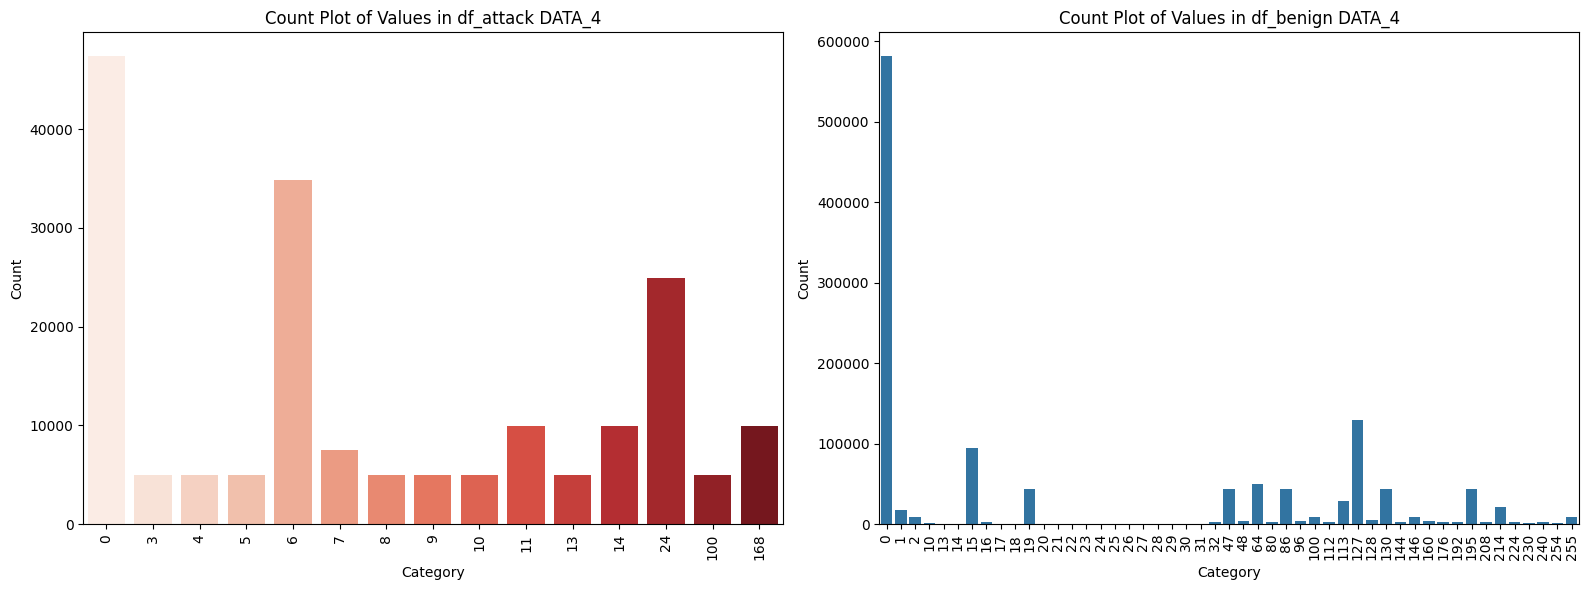

<ipython-input-11-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


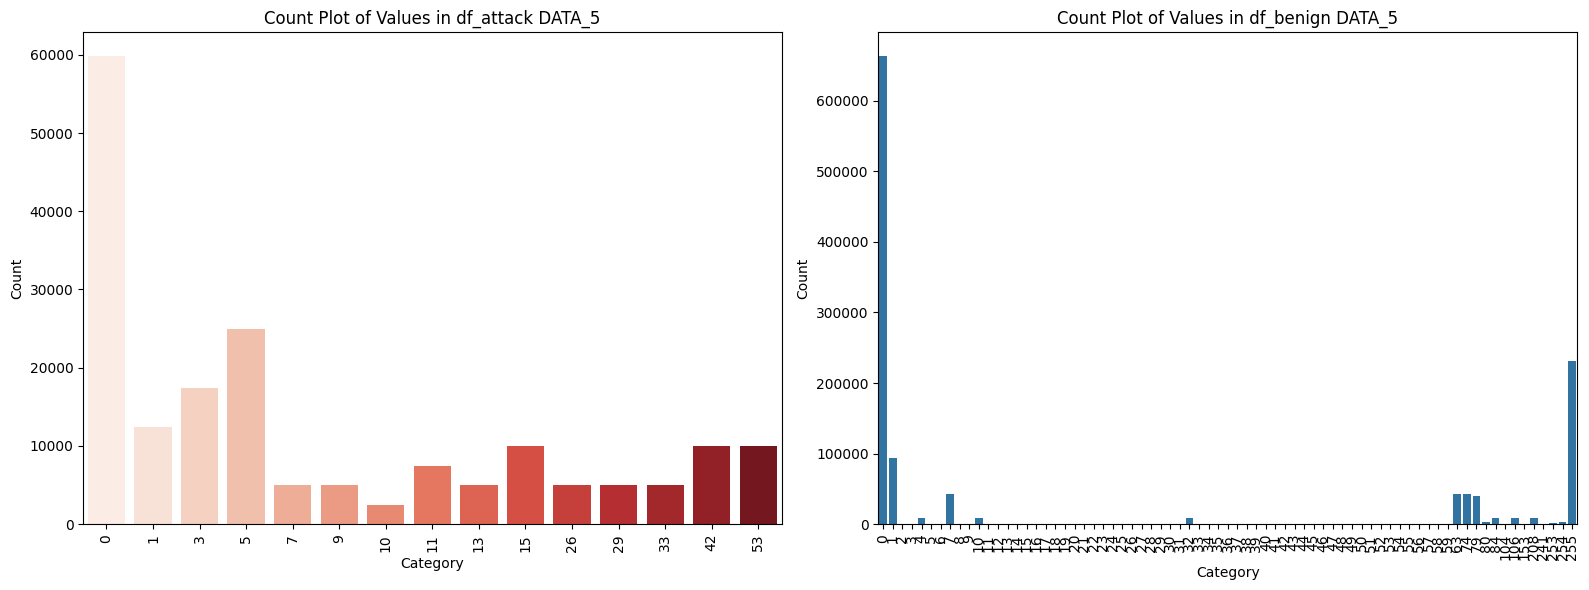

<ipython-input-11-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


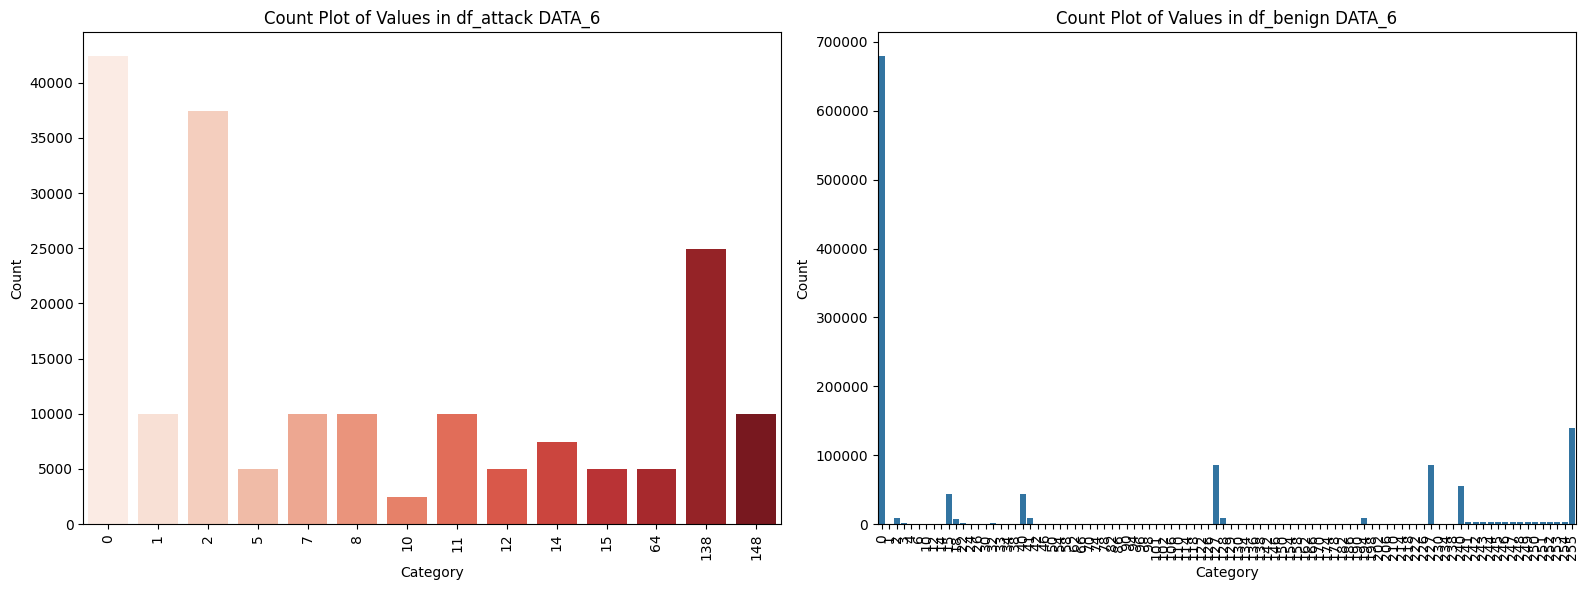

<ipython-input-11-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


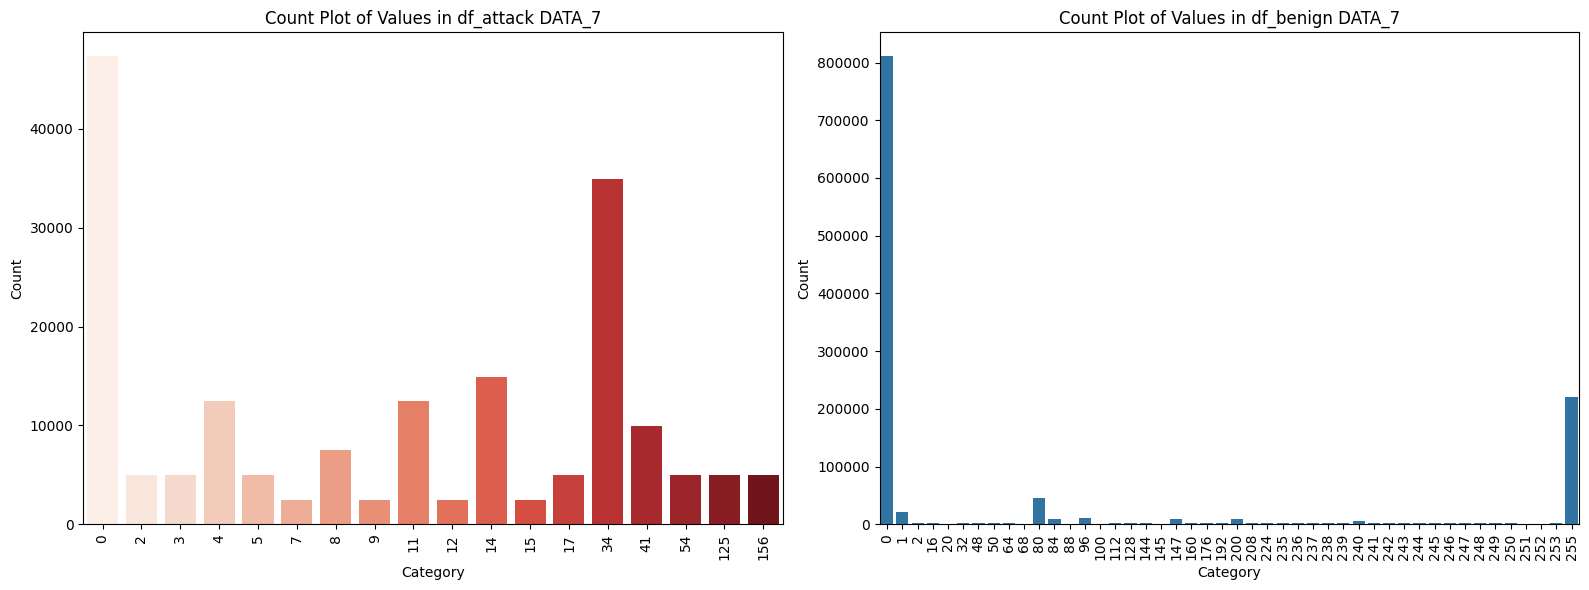

In [11]:
val = ['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']

for value in val:
  fig, axes = plt.subplots(1, 2, figsize=(16, 6))

  sns.countplot(
      data=df_attack,
      x=value,
      ax=axes[0],
      palette='Reds'
  )

  axes[0].set_title(f"Count Plot of Values in df_attack {value}")
  axes[0].set_xlabel("Category")
  axes[0].set_ylabel("Count")
  axes[0].tick_params(axis='x', rotation=90)

  # Plot du dataframe 'df_benign' sur le deuxième axe (à droite)
  sns.countplot(
      data=df_benign,
      x=value,
      ax=axes[1]
  )

  axes[1].set_title(f"Count Plot of Values in df_benign {value}")
  axes[1].set_xlabel("Category")
  axes[1].set_ylabel("Count")
  axes[1].tick_params(axis='x', rotation=90)

  # Afficher les plots
  plt.tight_layout()
  plt.show()

## Machine learning

### Classification binaire : Attaque ou pas attaque ?

Après recherches, nous avons determiné que l'algorythme RandomForest pouvait être efficient pour une détection binaire (attaque ou non) en utilisant les données décimales.

- 0 signifie un cas bénin
- 1 représente une attaque quel que soit son type

Pour la classification plus poussée (DoS/Spoofing, etc...) sur les données Décimales, nous

In [12]:
df_spoofing

,ID,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,category,specific_class
0,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
1,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
2,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
3,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
4,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
...,...,...,...,...,...,...,...,...,...,...,...,...
19972,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
19973,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
19974,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
19975,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL


<Axes: xlabel='specific_class', ylabel='Count'>

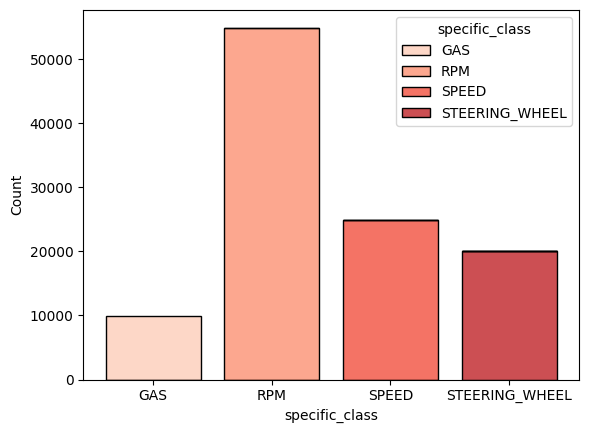

In [13]:
sns.histplot(
    data=df_spoofing,
    x='specific_class',
    hue='specific_class',
    multiple="stack",
    shrink=0.8,
    palette='Reds'
)

In [14]:
# Decimal
df_DoS = pd.read_csv('./decimal/decimal_DoS.csv')
df_spoofing_Gas = pd.read_csv('./decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('./decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('./decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('./decimal/decimal_spoofing-STEERING_WHEEL.csv')

df_benign = pd.read_csv('./decimal/decimal_benign.csv')
df_atk = pd.concat([df_DoS, df_spoofing_Gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering], ignore_index=True)


df_atk['isAttack'] = 1
df_benign['isAttack'] = 0

df_atk_clean = df_atk.drop(columns=['label','specific_class', 'category'])
df_benign_clean = df_benign.drop(columns=['label','specific_class', 'category'])


df_combined = pd.concat([df_atk, df_benign], ignore_index=True)
df_combined = df_combined.drop(columns=['label','specific_class', 'category'])

aggregated_df_atk = aggregate_columns(df_atk_clean, id_column='ID', group_size=100)
aggregated_df_benign = aggregate_columns(df_benign_clean, id_column='ID', group_size=100)

aggregated_df = pd.concat([aggregated_df_atk,aggregated_df_benign], ignore_index=True)

aggregated_df = aggregated_df.drop(columns=['ID'])


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:23:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost Decimal Aggregated ---
Accuracy: 1.0000
ROC AUC Score: 1.0000
Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      2434
      ATTACK       1.00      1.00      1.00       388

    accuracy                           1.00      2822
   macro avg       1.00      1.00      1.00      2822
weighted avg       1.00      1.00      1.00      2822





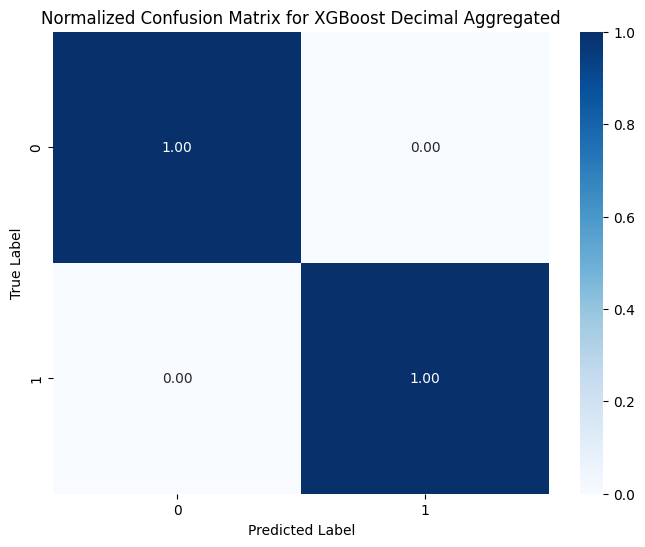

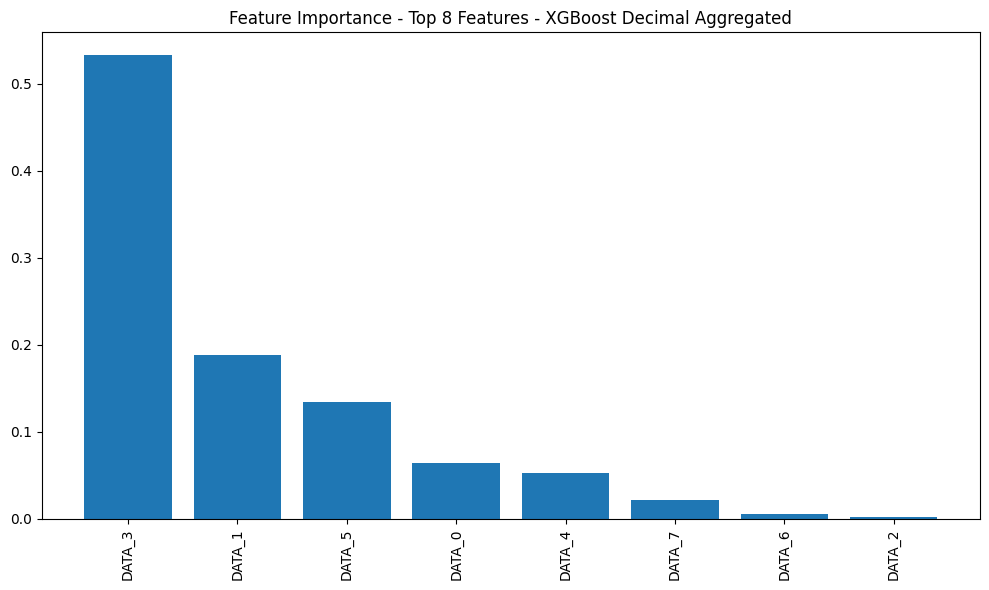

[LightGBM] [Info] Number of positive: 1459, number of negative: 9829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 11288, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129252 -> initscore=-1.907586
[LightGBM] [Info] Start training from score -1.907586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

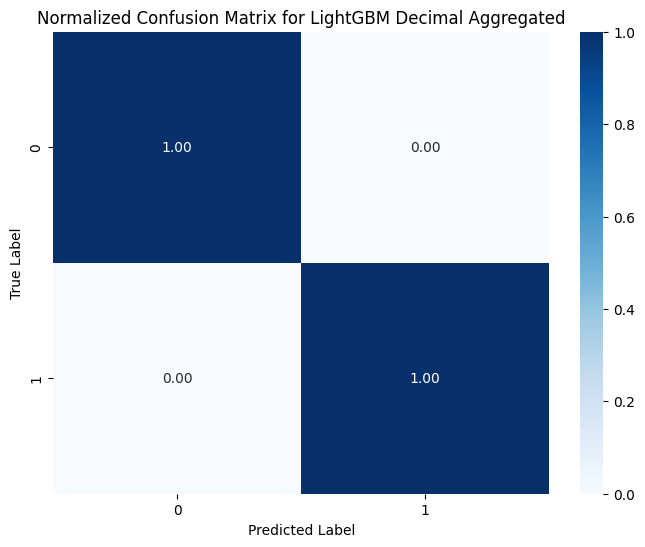

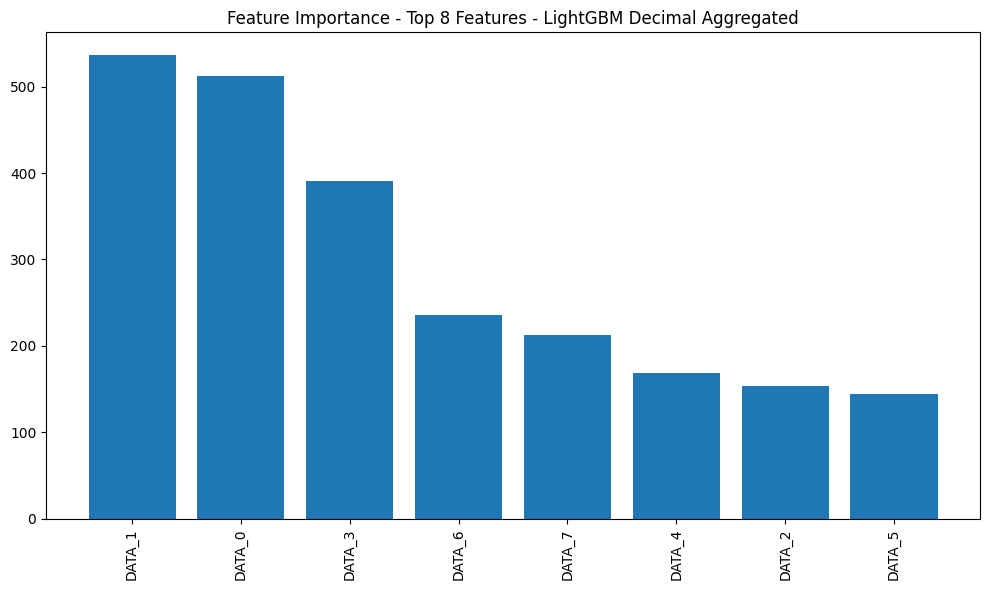

--- ExtraTrees Decimal Aggregated ---
Accuracy: 1.0000
ROC AUC Score: 1.0000
Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      2434
      ATTACK       1.00      1.00      1.00       388

    accuracy                           1.00      2822
   macro avg       1.00      1.00      1.00      2822
weighted avg       1.00      1.00      1.00      2822





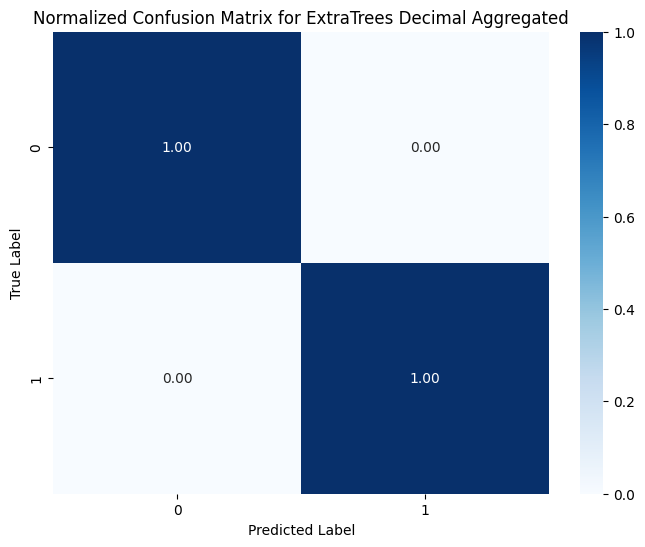

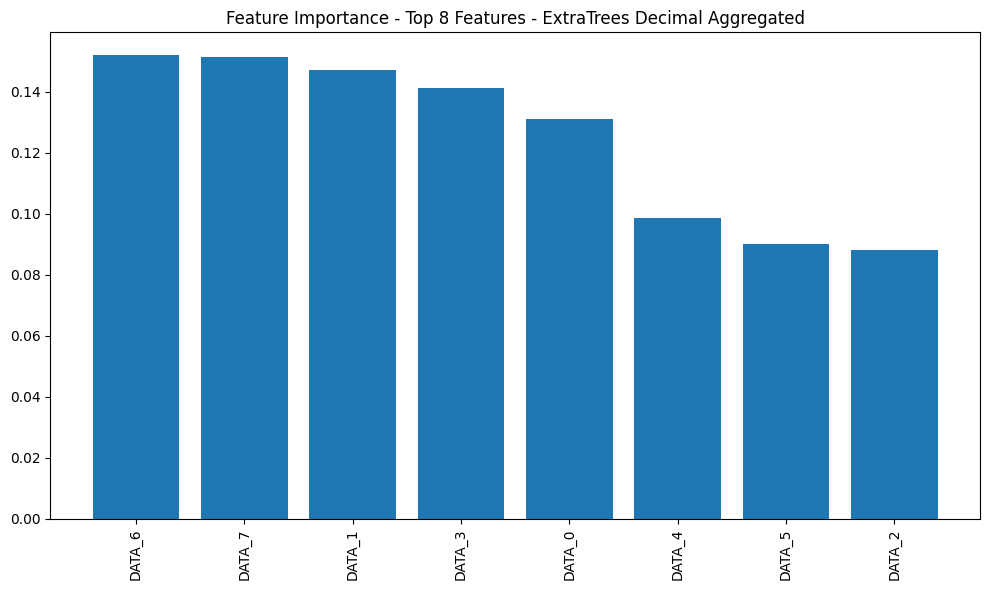

In [15]:
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "ExtraTrees": ExtraTreesClassifier()
}

X_train,X_test,y_train,y_test = prepare_data(aggregated_df)
train_and_evaluate(models, X_train, X_test, y_train, y_test, "Decimal Aggregated")


In [16]:
df_total_entries = pd.concat([df_atk_clean, df_benign_clean], ignore_index = True)
df_total_entries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408219 entries, 0 to 1408218
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   ID        1408219 non-null  int64
 1   DATA_0    1408219 non-null  int64
 2   DATA_1    1408219 non-null  int64
 3   DATA_2    1408219 non-null  int64
 4   DATA_3    1408219 non-null  int64
 5   DATA_4    1408219 non-null  int64
 6   DATA_5    1408219 non-null  int64
 7   DATA_6    1408219 non-null  int64
 8   DATA_7    1408219 non-null  int64
 9   isAttack  1408219 non-null  int64
dtypes: int64(10)
memory usage: 107.4 MB


In [17]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgbm_model = LGBMClassifier()

# xgb_model.fit(X_train, y_train)
# lgbm_model.fit(X_train, y_train)

models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(min_split_gain=0, verbose=-1),
}

# feature_importances = {
#     'XGBoost': xgb_model.feature_importances_,
#     'LightGBM': lgbm_model.feature_importances_,
# }

In [25]:
execution_times = []
false_negatives_cases = []

i = 100
max = 200


# i_tab = [30, 120]
while i < max :
    aggregated_df_atk = aggregate_columns(df_atk_clean, id_column='ID', group_size=i)
    aggregated_df_benign = aggregate_columns(df_benign_clean, id_column='ID', group_size=i)
    aggregated_df = pd.concat([aggregated_df_atk, aggregated_df_benign], ignore_index=True)
    aggregated_df = aggregated_df.drop(columns=['ID'])
    # aggregated_df['unique'] = aggregated_df.nunique(axis=1)
    aggregated_df['gradient_sum'] = aggregated_df.diff(axis=1).sum(axis=1)
    aggregated_df['gradient_std'] = aggregated_df.diff(axis=1).std(axis=1)

    X_train, X_test, y_train, y_test = prepare_data(aggregated_df)

    misclassification_occurred = False
    misclassification_true_negativ = 0
    misclassification_false_positiv = 0

    start_time = time.time()

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        plot_feature_importance(model, model_name, X_train.columns)

        for idx, (true_label, pred_label) in enumerate(zip(y_test, predictions)):
            if true_label == 1 and pred_label == 0:  # False negative
                misclassification_occurred = True
                misclassification_true_negativ += 1
                false_negatives_cases.append((i, X_test.iloc[idx], true_label, pred_label))

            if true_label == 0 and pred_label == 1:  # False positive
                misclassification_occurred = True
                misclassification_false_positiv += 1

    execution_time = time.time() - start_time
    execution_times.append((i, execution_time, not misclassification_occurred, misclassification_true_negativ, misclassification_false_positiv))

    i += 10

false_negatives_df = pd.DataFrame(false_negatives_cases, columns=['Group Size (i)', 'Feature Values', 'True Label', 'Predicted Label'])

print("False Negatives Cases:")
print(false_negatives_df)

execution_times_df = pd.DataFrame(execution_times, columns=['Group Size (i)', 'Execution Time (s)', 'No Misclassification', 'True Negativ', 'False Positiv'])
execution_times_df['Total Misclassifications'] = execution_times_df['True Negativ'] + execution_times_df['False Positiv']

plt.figure(figsize=(10, 6))
plt.plot(execution_times_df['Group Size (i)'], execution_times_df['Total Misclassifications'], marker='x', label='Total Misclassifications')
plt.xlabel('Group Size (i)')
plt.ylabel('Number of Misclassifications')
plt.title('Number of Misclassifications by Group Size')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(execution_times_df['Group Size (i)'], execution_times_df['Execution Time (s)'], marker='o', label='Execution Time (s)')
plt.xlabel('Group Size (i)')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time by Group Size')
plt.legend()
plt.tight_layout()
plt.show()


KeyError: "['isAttack'] not found in axis"

In [19]:
df_DoS = pd.read_csv('./decimal/decimal_DoS.csv')
df_DoS['isDos'] = 1;
df_spoofing_Gas = pd.read_csv('./decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('./decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('./decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('./decimal/decimal_spoofing-STEERING_WHEEL.csv')

df_spoofing = pd.concat([df_spoofing_Gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering], ignore_index=True)
df_spoofing['isDos']=0

df_DoS = df_DoS.drop(columns=['label', 'specific_class', 'category'])
df_spoofing = df_spoofing.drop(columns=['label', 'specific_class', 'category'])


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:27:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:27:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:27:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:27:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:27:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

False Negatives Cases:
Empty DataFrame
Columns: [Group Size (i), Feature Values, True Label, Predicted Label]
Index: []


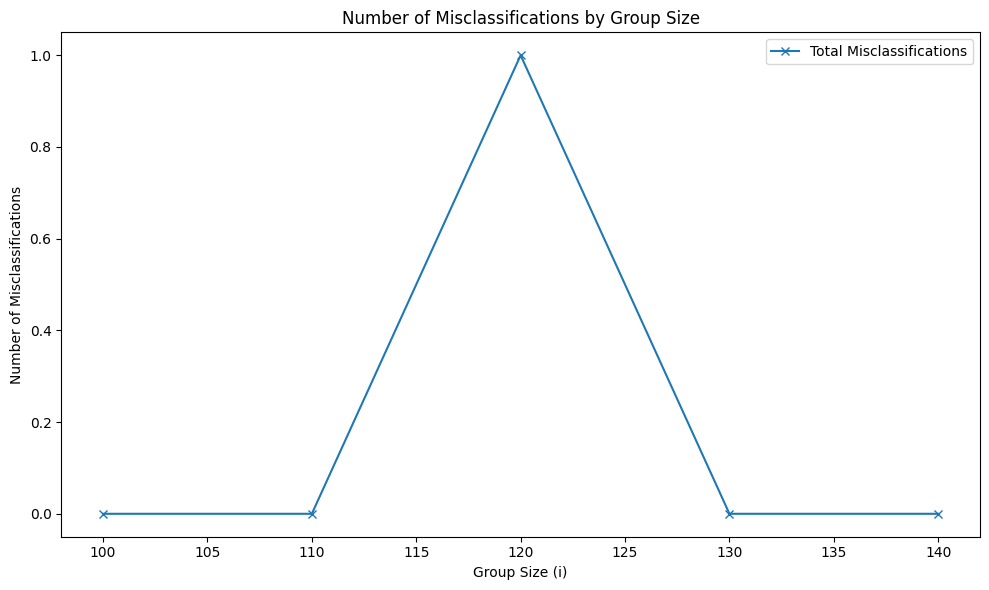

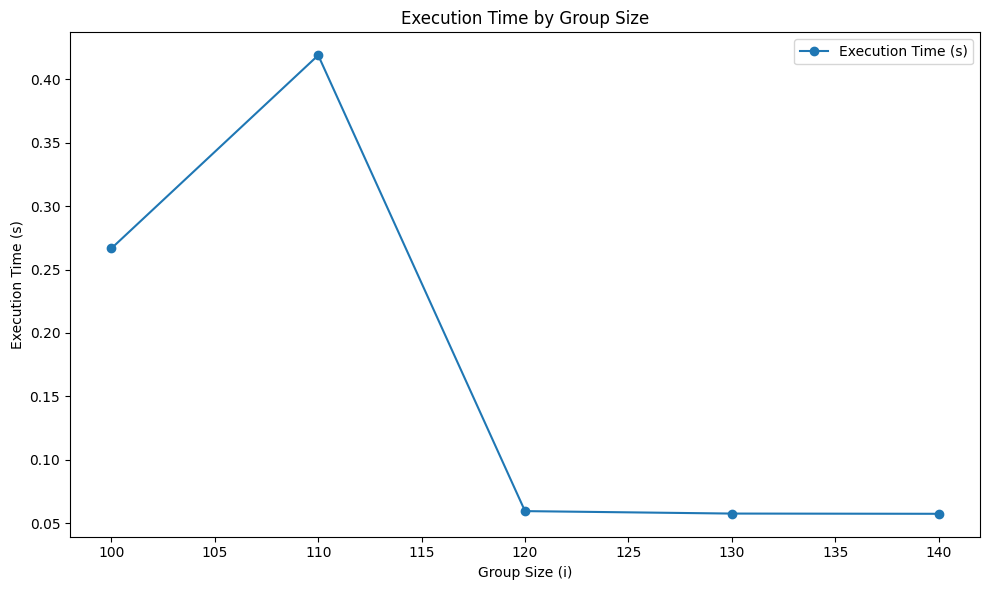

In [20]:
execution_times = []
false_negatives_cases = []

i = 100
# i_tab = [30, 120]
while i < 150 :
    aggregated_df_atk_dos = aggregate_columns(df_DoS, id_column='ID', group_size=i)
    aggregated_df_atk_spoofing = aggregate_columns(df_spoofing, id_column='ID', group_size=i)
    aggregated_df = pd.concat([aggregated_df_atk_dos, aggregated_df_atk_spoofing], ignore_index=True)
    aggregated_df = aggregated_df.drop(columns=['ID'])
    # aggregated_df['unique'] = aggregated_df.nunique(axis=1)
    aggregated_df['gradient_sum'] = aggregated_df.diff(axis=1).sum(axis=1)
    aggregated_df['gradient_std'] = aggregated_df.diff(axis=1).std(axis=1)


    X_train, X_test, y_train, y_test = prepare_data_dos(aggregated_df)

    misclassification_occurred = False
    misclassification_true_negativ = 0
    misclassification_false_positiv = 0

    start_time = time.time()

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        for idx, (true_label, pred_label) in enumerate(zip(y_test, predictions)):
            if true_label == 1 and pred_label == 0:  # False negative
                misclassification_occurred = True
                misclassification_true_negativ += 1
                false_negatives_cases.append((i, X_test.iloc[idx], true_label, pred_label))

            if true_label == 0 and pred_label == 1:  # False positive
                misclassification_occurred = True
                misclassification_false_positiv += 1

    execution_time = time.time() - start_time
    execution_times.append((i, execution_time, not misclassification_occurred, misclassification_true_negativ, misclassification_false_positiv))

    i += 10

false_negatives_df = pd.DataFrame(false_negatives_cases, columns=['Group Size (i)', 'Feature Values', 'True Label', 'Predicted Label'])

print("False Negatives Cases:")
print(false_negatives_df)

execution_times_df = pd.DataFrame(execution_times, columns=['Group Size (i)', 'Execution Time (s)', 'No Misclassification', 'True Negativ', 'False Positiv'])
execution_times_df['Total Misclassifications'] = execution_times_df['True Negativ'] + execution_times_df['False Positiv']

plt.figure(figsize=(10, 6))
plt.plot(execution_times_df['Group Size (i)'], execution_times_df['Total Misclassifications'], marker='x', label='Total Misclassifications')
plt.xlabel('Group Size (i)')
plt.ylabel('Number of Misclassifications')
plt.title('Number of Misclassifications by Group Size')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(execution_times_df['Group Size (i)'], execution_times_df['Execution Time (s)'], marker='o', label='Execution Time (s)')
plt.xlabel('Group Size (i)')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time by Group Size')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
df_DoS = pd.read_csv('./decimal/decimal_DoS.csv')
df_spoofing_Gas = pd.read_csv('./decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('./decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('./decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('./decimal/decimal_spoofing-STEERING_WHEEL.csv')
df_benign = pd.read_csv('./decimal/decimal_benign.csv')


df_DoS['is_spoofing'] = 0
df_spoofing_Gas['is_spoofing'] = 1
df_spoofing_RPM['is_spoofing'] = 1
df_spoofing_speed['is_spoofing'] = 1
df_spoofing_steering['is_spoofing'] = 1
df_benign['is_spoofing'] = 0

df_atk = pd.concat(
    [df_DoS, df_spoofing_Gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering],
    ignore_index=True
)

df_atk['isMechant'] = 1
df_benign['isMechant'] = 0

df_atk_clean = df_atk.drop(columns=['label', 'specific_class', 'category'])
df_benign_clean = df_benign.drop(columns=['label', 'specific_class', 'category'])

df_combined = pd.concat([df_atk, df_benign], ignore_index=True)
df_combined = df_combined.drop(columns=['label', 'specific_class', 'category'])


aggregated_df_atk = aggregate_columns(df_atk_clean, id_column='ID', group_size=i)
aggregated_df_benign = aggregate_columns(df_benign_clean, id_column='ID', group_size=i)

aggregated_df = pd.concat([aggregated_df_atk, aggregated_df_benign], ignore_index=True)
aggregated_df = aggregated_df.drop(columns=['ID'])


def prepare_full_df():
    df_atk['spoofing_type'] = 0
    df_atk.loc[df_atk['specific_class'] == 'GAS', 'spoofing_type'] = 1
    df_atk.loc[df_atk['specific_class'] == 'RPM', 'spoofing_type'] = 2
    df_atk.loc[df_atk['specific_class'] == 'SPEED', 'spoofing_type'] = 3
    df_atk.loc[df_atk['specific_class'] == 'STEERING_WHEEL', 'spoofing_type'] = 4

    df_atk['spoofing_type'] -= 1

    df_benign['spoofing_type'] = 0

    df_atk.drop(columns=['label', 'specific_class', 'category'], inplace=True)
    df_benign.drop(columns=['label', 'specific_class', 'category'], inplace=True)

    df_atk.to_csv('./decimal/decimal_full_atk.csv', index=False)
    df_benign.to_csv('./decimal/decimal_full_benign.csv', index=False)


try :

    full_df_atk = pd.read_csv('./decimal/decimal_full_atk.csv')
    full_df_benign = pd.read_csv('./decimal/decimal_full_benign.csv')
except FileNotFoundError:
    print('[!] full_df files not found, creating it... It can take few minutes')
    prepare_full_df()
    full_df_atk = pd.read_csv('./decimal/decimal_full_atk.csv')
    full_df_benign = pd.read_csv('./decimal/decimal_full_benign.csv')



[!] full_df files not found, creating it... It can take few minutes


[!] full_df_aggeated.csv not found, creating it... It can take few minutes


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:28:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:28:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-5-0476b39e7d73>:284: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(["Execution Time"])


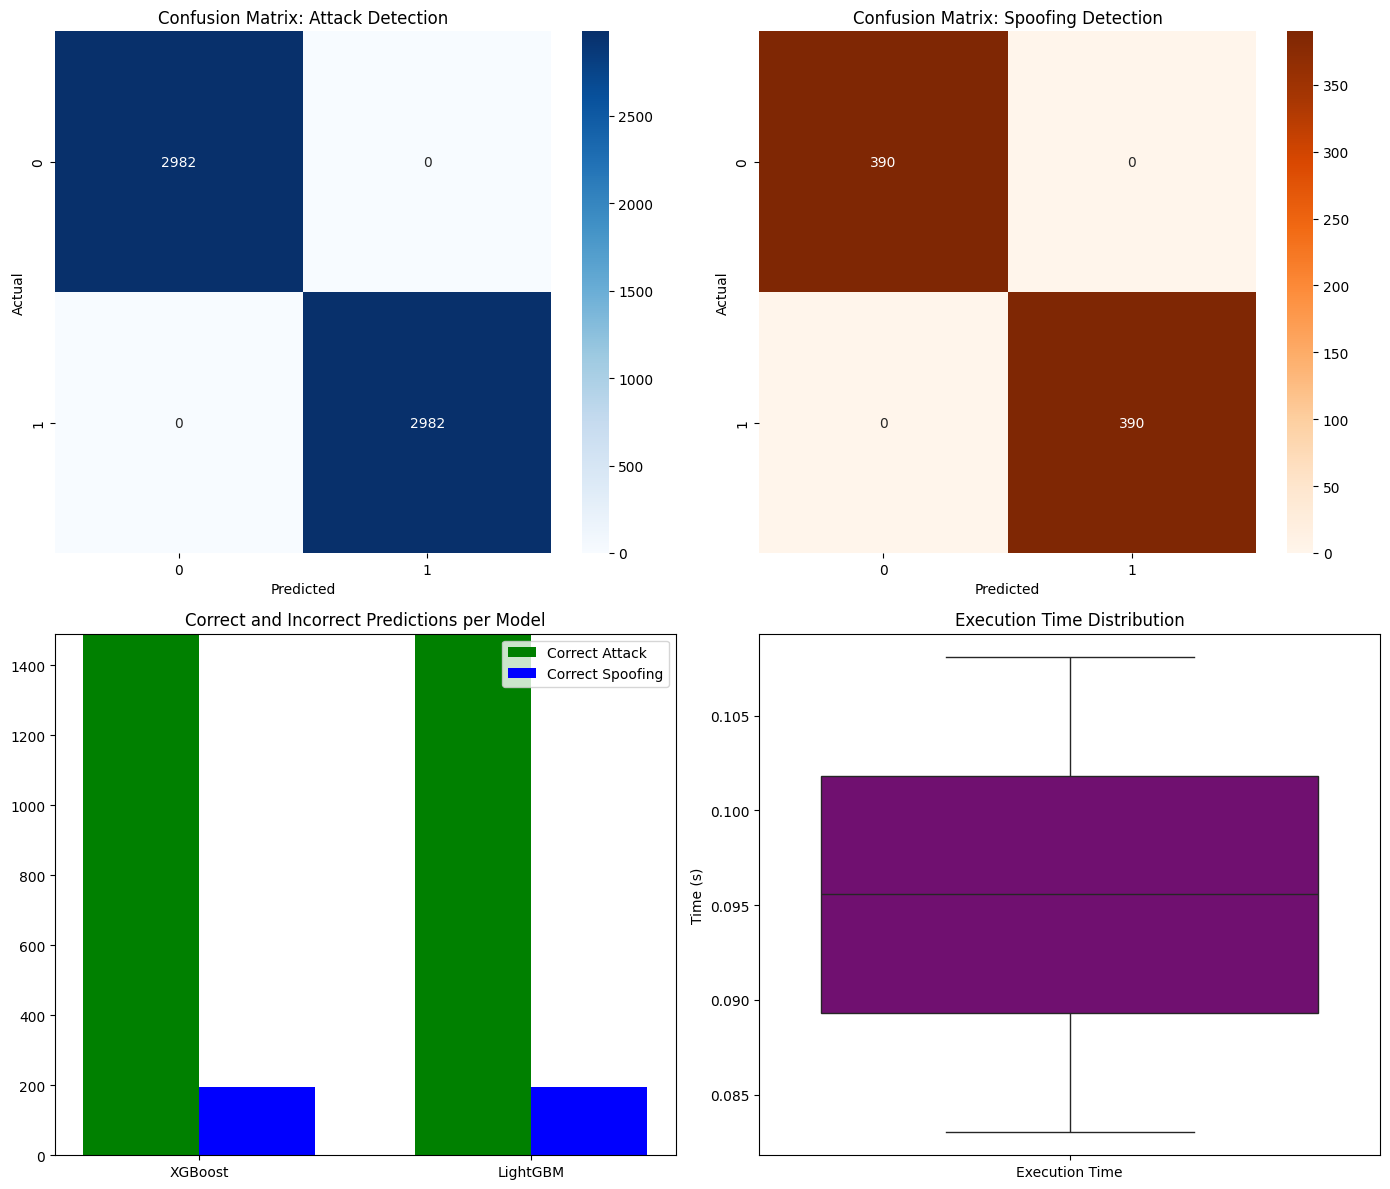


--- Results Summary ---
      Model  Correct Predictions (Attack)  Incorrect Predictions (Attack)  \
0   XGBoost                          1491                               0   
1  LightGBM                          1491                               0   

   Correct Predictions (Spoofing)  Incorrect Predictions (Spoofing)  \
0                             195                                 0   
1                             195                                 0   

   Execution Time (s)  
0            0.083048  
1            0.108072  

Total Correct Predictions (Attack): 2982
Total Incorrect Predictions (Attack): 0
Total Correct Predictions (Spoofing): 390
Total Incorrect Predictions (Spoofing): 0


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-5-0476b39e7d73>:385: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(["Execution Time"])


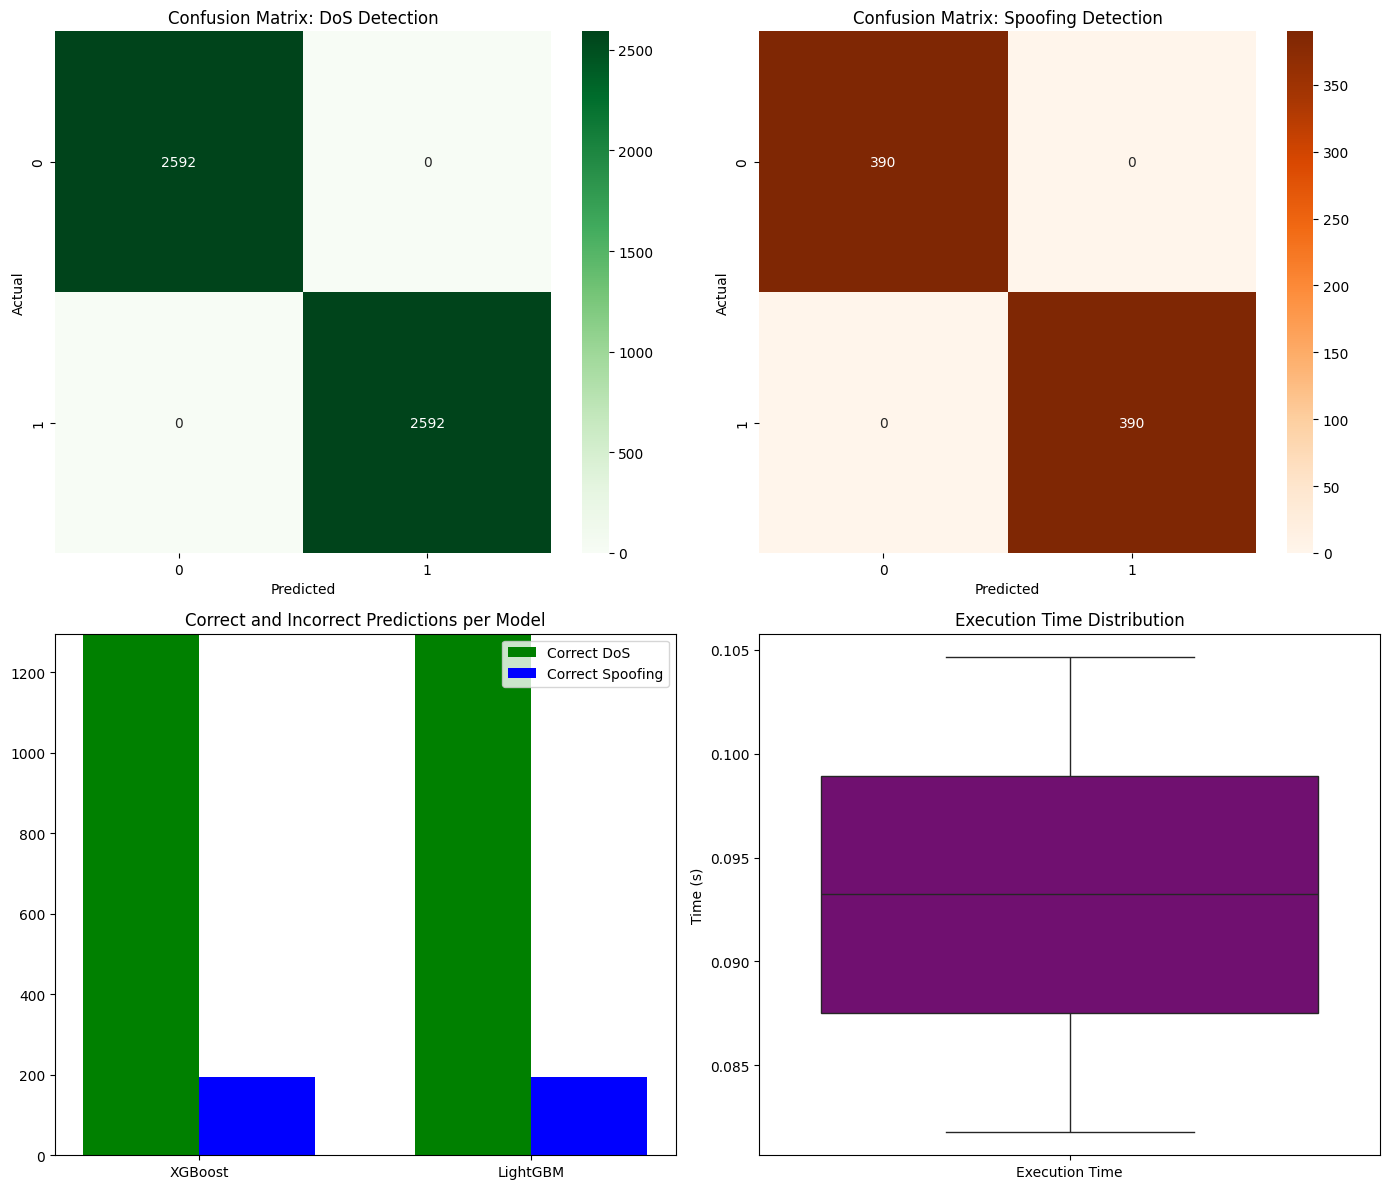


--- Results Summary ---
      Model  Correct Predictions (DoS)  Incorrect Predictions (DoS)  \
0   XGBoost                       1296                            0   
1  LightGBM                       1296                            0   

   Correct Predictions (Spoofing)  Incorrect Predictions (Spoofing)  \
0                             195                                 0   
1                             195                                 0   

   Execution Time (s)  
0            0.081809  
1            0.104644  

Total Correct Predictions (DoS): 2592
Total Incorrect Predictions (DoS): 0
Total Correct Predictions (Spoofing): 390
Total Incorrect Predictions (Spoofing): 0


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-5-0476b39e7d73>:501: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(["Execution Time"])


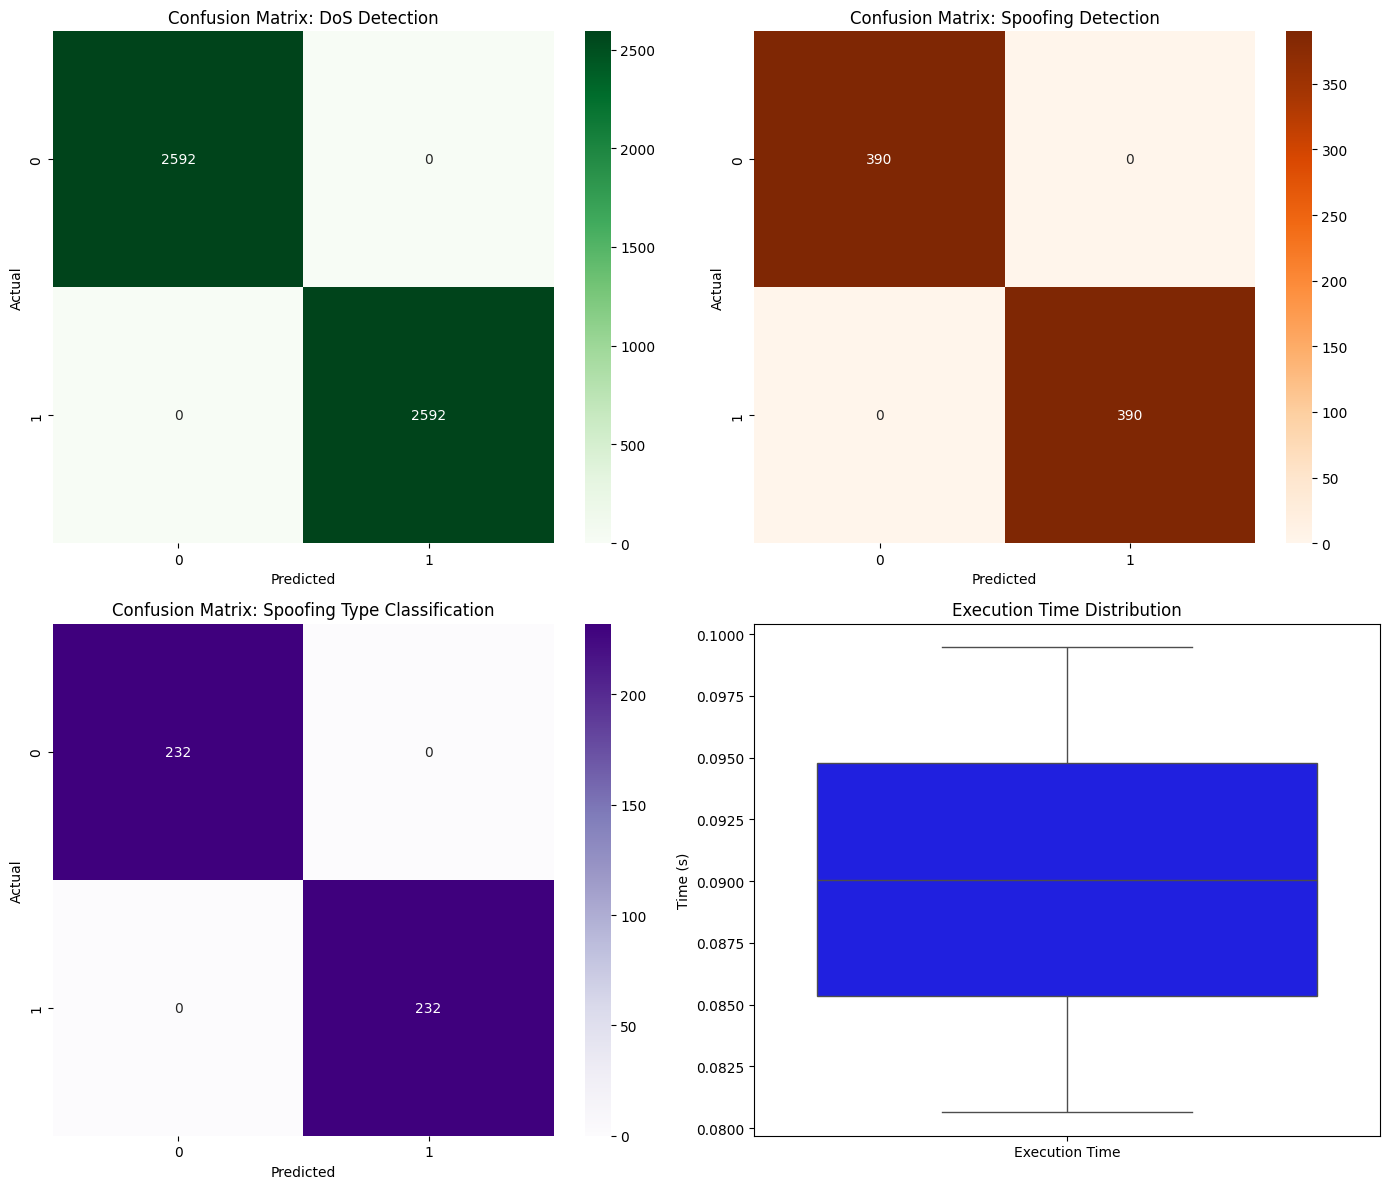


--- Results Summary ---
      Model  Correct Predictions (DoS)  Incorrect Predictions (DoS)  \
0   XGBoost                       1296                            0   
1  LightGBM                       1296                            0   

   Correct Predictions (Spoofing)  Incorrect Predictions (Spoofing)  \
0                             195                                 0   
1                             195                                 0   

   Correct Predictions (Spoofing Type)  Incorrect Predictions (Spoofing Type)  \
0                                  116                                      0   
1                                  116                                      0   

   Execution Time (s)  
0            0.080637  
1            0.099473  

Total Correct Predictions (DoS): 2592
Total Incorrect Predictions (DoS): 0
Total Correct Predictions (Spoofing): 390
Total Incorrect Predictions (Spoofing): 0
Total Correct Predictions (Spoofing Type): 232
Total Incorrect Predicti

XGBoostError: value 0 for Parameter num_class should be greater equal to 1
num_class: Number of output class in the multi-class classification.

In [22]:
i = 190
max = 200
while i < max:

  try :
      full_df_aggregated = pd.read_csv('/content/full_df_aggregated.csv')
  except FileNotFoundError:
      print("[!] full_df_aggeated.csv not found, creating it... It can take few minutes")
      full_df_atk_aggregated = aggregate_columns2(pd.read_csv('/content/decimal/decimal_full_atk.csv'), id_column='ID', group_size=i)
      full_df_benign_aggregated = aggregate_columns2(pd.read_csv('/content/decimal/decimal_full_benign.csv'), id_column='ID', group_size=i)

      full_df_aggregated = pd.concat([full_df_atk_aggregated, full_df_benign_aggregated], ignore_index=True)

      full_df_aggregated.to_csv('/content/full_df_aggregated.csv', index=False)

  df1 = full_df_aggregated.copy()
  df2 = full_df_aggregated.copy()
  df2['spoofing_type'] += 1

  diagnosticv1 = diagnosticv1(models=models,df=df1)
  diagnosticv2 = diagnosticv2(models=models,df=df1)
  diagnosticv3 = diagnosticv3(models=models,df=df1)
  diganostic_final = diagnostic_final(models=models,df=df2)

<Axes: xlabel='category', ylabel='Count'>

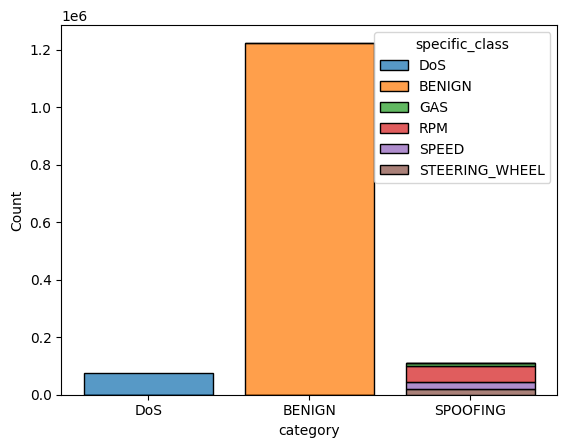

In [23]:
sns.histplot(
    data=df, x='category',
    hue='specific_class',
    multiple="stack",
    shrink=0.8
)